# Forecasting cropland vegetation condition 

* **Products used:** 
[s2_l2a](https://explorer.digitalearth.africa/s2_l2a), [crop_mask_eastern](https://explorer.digitalearth.africa/crop_mask_eastern)

## Background

This notebook conducts time-series forecasting of vegetation condition (NDVI) using SARIMAX, a variation on [autoregressive-moving-average (ARMA)](https://en.wikipedia.org/wiki/Autoregressive%E2%80%93moving-average_model#ARMAX) models which includes an integrated (I) component to difference the timeseries so it becomes stationary, a seasonal (S) component, and has the capacity to consider exogenous (X) variables. 

## Description

In this notebook, we generate a NDVI timeseries from Sentinel-2, then use it develop a forecasting algorithm.

The following steps are taken:

1. Load Sentinel-2 data and calculate NDVI.
2. Test for stationarity.
3. Conduct a cross-validation forecast and inspect results to check forecast performance.
4. Forecast NDVI into the future.

***

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline
import datacube
import xarray as xr
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm
from itertools import product
from datacube import Datacube
from matplotlib import pyplot as plt

from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import display_map
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.dask import create_local_dask_cluster

from statsmodels.tools.eval_measures import rmse
import statsmodels.api as sm

In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:38043 Dashboard: /user/mickwelli/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 13.11 GB


### Connect to the datacube

In [3]:
dc = datacube.Datacube(app="NDVI_forecast")

## Analysis parameters

* `lat`, `lon`: The central latitude and longitude to analyse. In this example we'll used grasslands in the Serengeti.
* `buffer`: The number of square degrees to load around the central latitude and longitude. For reasonable loading times, set this as 0.1 or lower
* `time_range`: The date range to analyse.
* `freq`: The frequency we want to resample the time-series to e.g. for monthly time steps use `'1M'`, for fortinightly use `'2W'`
* `dask_chunks`: How to chunk the datasets to work with dask

In [4]:
# Define the analysis region (Lat-Lon box)
lat, lon = 8.5593, 40.6975 # grasslands in serengeti
buffer = 0.04

products = "s2_l2a"

# Define the time window for defining the model
time_range = ('2017-01-01', '2022-01')

#resample frequency
freq='1M'

forecast_length = 6

resolution = (-20,20)

#dask chunk sizes
dask_chunks={'x':500, 'y':500, 'time':-1}

## Display analysis area on an interactive map

In [5]:
lon=(lon - buffer, lon + buffer)
lat=(lat - buffer, lat + buffer)

display_map(lon,lat)

### Load the satellite data

In [6]:
# set up a datcube query object
query = {'x': lon, 'y': lat,
         'time': time_range,
         'measurements':['red', 'nir'],
         'output_crs' :'EPSG:6933',
         'resolution' : resolution,
         'resampling' :{"fmask": "nearest", "*": "bilinear"}}

In [7]:
# load the satellite data
ds = load_ard(dc=dc, 
              dask_chunks=dask_chunks,
              products=products,
              **query)
print(ds)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Applying pixel quality/cloud mask
Returning 701 time steps as a dask array
<xarray.Dataset>
Dimensions:      (time: 701, y: 505, x: 387)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-06T07:42:19 ... 2022-01-25T07:...
  * y            (y) float64 1.093e+06 1.093e+06 ... 1.083e+06 1.083e+06
  * x            (x) float64 3.923e+06 3.923e+06 ... 3.931e+06 3.931e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(701, 500, 387), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(701, 500, 387), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


## Mask region with DE Africa's cropland extent map

Load the cropland mask over the region of interest. The default region we're analysing is in Ethiopia, so we need to load the [crop_mask_eastern](https://explorer.digitalearth.africa/products/crop_mask_eastern/extents) product, which cover the countries of Ethiopia, Kenya, Tanzania, Rwanda, and Burundi


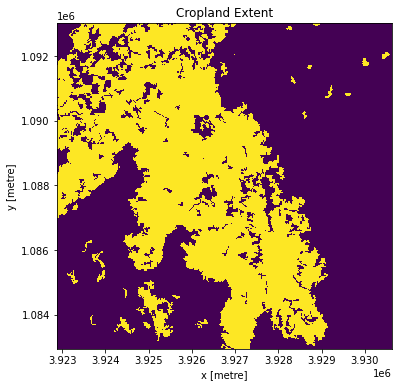

In [8]:
cm = dc.load(product='crop_mask_eastern',
            time=('2019'),
            measurements='filtered',
            resampling='nearest', 
            like=ds.geobox).filtered.squeeze()

cm.plot.imshow(add_colorbar=False, figsize=(6,6))
plt.title('Cropland Extent');

Now we will use the cropland map to mask the regions in the Sentinel-2 data that only have cropping. 

In [9]:
ds = ds.where(cm)

## Calculate NDVI and clean the time-series


Afrter calculating NDVI, we will smooth and interpolate the data to ensure we working with a consistent time-series. This is a very important step in the workflow and there are many ways to smooth, interpolate, gap-fill, remove outliers, or curve-fit the data to ensure a consistent time-series. If not using the default example, you may have to define additional methods to those used here.

To do this we take two steps:

1. Resample the data to fortnightly time-steps using the fortnightly median
2. Calculate a rolling mean with a window of 4 steps

In [10]:
#calculate NDVI
ndvi = calculate_indices(ds, 'NDVI', drop=True, collection='s2')

Dropping bands ['red', 'nir']


In [11]:
#resample and smooth
window=4

ndvi=ndvi.resample(time=freq).median().rolling(time=window, min_periods=1, center=True).mean()

### Reduce the time-series to 1 dimension

In [12]:
ndvi=ndvi.mean(['x','y'])
ndvi = ndvi.NDVI.compute()

#### Plot the NDVI timeseries

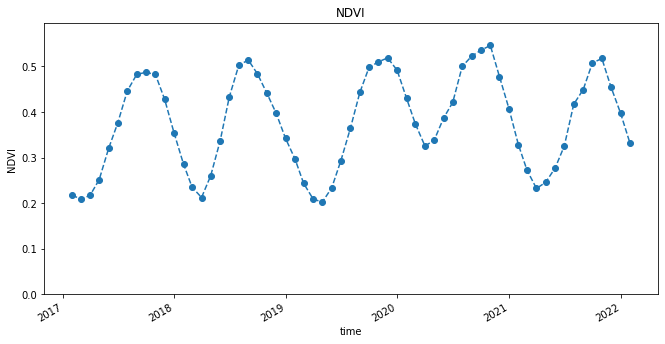

In [13]:
ndvi.plot(figsize=(11,5),linestyle='dashed', marker='o')
plt.title('NDVI')
plt.ylim(0,ndvi.max().values+0.05);

## Split data and fit a model

### Split training and test data

Cross-validation is a common method for evaluating model performance. It involves dividing data into a training set on which the model is trained, and test (or validation) set, to which the model is applied to produce predictions which are compared against actual values (that weren't used in model training).

In [14]:
ndvi = ndvi.drop('spatial_ref').to_dataframe()
train_data = ndvi['NDVI'][:len(ndvi)-10] # remove the last ten observations and keep them as test data
test_data = ndvi['NDVI'][len(ndvi)-10:]

## Iteratively find the best paramters for the SARIMAX model

SARIMAX models are fitted with parameters for both the trend and seasonal components of the timeseries. The parameters can be defined as:
* Trend elements
    * **p**: Autoregression order. This is the number of immediately preceding values in the series that are used to predict the value at the present time.
    * **d**: Difference order. The number of times that differencing is performed is called the difference order.
    * **q**: Moving average order. The size of the moving average window.
* Seasonal elements are as above, but for the seasonal component of the timeseries.
    * **P**
    * **D**
    * **Q**

In [ ]:
#Set initial values and some bounds
ps = range(0, 3)
d = 1
qs = range(0, 3)
Ps = range(0, 3)
D = 1
Qs = range(0, 3)
s = 6

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print(len(parameters_list))

# Train many SARIMA models to find the best set of parameters
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm(parameters_list):
        try:
            import warnings
            warnings.filterwarnings("ignore")
            model = sm.tsa.statespace.SARIMAX(train_data, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
            
            pred = model.predict(start=len(train_data), end=(len(ndvi)-1))
            error = rmse(pred, test_data)
        
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic, error])
        
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic', 'error']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='error', ascending=True).reset_index(drop=True)
    
    return result_table


## Selection criterion

We can use either the [Akaike information criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion) or [Bayesian information criterion (BIC)](https://en.wikipedia.org/wiki/Bayesian_information_criterion) for model selection. Both these criteria aim to optimise the trade-off between goodness of fit and model simplicity. That is, we are aiming to find the model that can explain the most variation in the timeseries with the least complexity. The BIC penalises additional parameters (greater complexity) more than the AIC. 

There are different schools of thought on which criterion to use. A general rule of thumb is that the BIC should be used for inference and interpretation whereas the AIC should be used for prediction. We use the AIC in this instance as our goal is prediction (forecasting).

Another means of assessing predictive model performance is through cross-validation on test data, which we will perform in the next section on our selected. 

The cell below presents the top 15 models based on AIC and the RMSE on the cross-validation. In this case, we select the model with the lowest RMSE from cross-validation, though we could also select the model with the lowest AIC.

In [ ]:
result_table = optimize_SARIMA(parameters_list, d, D, s)

#Sort table by the lowest AIC (Akaike Information Criteria) where the RMSE is low
result_table = result_table.sort_values('aic').sort_values('error')
print(result_table[0:15])

In [ ]:
#select params
p, q, P, Q = result_table.iloc[0].parameters
print(result_table.iloc[0])

#fit the model with the parameters identified above
best_model = sm.tsa.statespace.SARIMAX(train_data, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)


## Perform cross-validation on test data

We saved the last 10 observations as test data above. Now we can use our model to predict NDVI for those time-steps and compare those predictions with actual values. We can do this visually in the graph below and also quantify the error with the root-mean-square error (RMSE).

In [ ]:
pred = best_model.predict(start=len(train_data), end=(len(ndvi)-1))

plt.figure(figsize=(11,5))
pred.plot(label='forecast', linestyle='dashed', marker='o')
train_data.plot(label='training data', linestyle='dashed', marker='o')
test_data.plot(label='test data', linestyle='dashed', marker='o')
plt.legend(loc="upper left");

### Check RMSE on test data

The root-mean-square error (RMSE) is a common metric used to evaluate model or forecast performance. It is the standard deviation of residuals (difference between forecast and actual value) expressed in units of the variable of interest e.g. NDVI.

In [ ]:
print('rmse value for NDVI is : ', round(rmse(pred, test_data),2))

### Plot model diagnostics

There are some typical plots we can use to evaluate our model. 

1. **Standardised residuals (top-left)**
    The standardised residuals are plotted against x (time) values. This allows us to check that variance (distance of residuals from 0) is constant across time values. There should be no obvious patterns.
    
2. **Histogram and estimated density**
    A kernel density estimation (KDE) is an estimated probability density function fitted on the actual distribution (histogram) of standardised residuals. A normal distribution (N (0,1)) is shown for reference. This plot shows that the distribution of our standardised residuals is close to normally distributed.
    
3. **Normal quantile-quantile (Q-Q) plot**
     This plot shows 'expected' or 'theoretical' quantiles drawn from a normal distribution on the x-axis against quantiles taken from the sample of residuals on the y-axis. If the observations in blue match the 1:1 line in red, then we can conclude that our residuals are normally distributed.
     
4. **Correlogram**
    The correlations for lags greater than 0 should not be statistically significant. That is, they should not be outside the blue ribbon.
    

In [ ]:
fig = plt.figure(figsize=(16, 9))
fig = best_model.plot_diagnostics(lags=25, fig=fig)

## Plot the result of our forecast

Our model looks good in the diagnostic plots above, so we will use it to forecast NDVI into the future. 

This time, we'll run a model on the entire time series so we can include the latest observations.

In [ ]:
final_model = sm.tsa.statespace.SARIMAX(ndvi, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

yhat = final_model.get_forecast(forecast_length);

In [ ]:
fig,ax=plt.subplots(1,1, figsize=(11,5))
yhat.predicted_mean.plot(label='NDVI forecast',ax=ax, linestyle='dashed', marker='o')
ax.fill_between(yhat.predicted_mean.index, yhat.conf_int()['lower NDVI'],yhat.conf_int()['upper NDVI'], alpha=0.2)
ndvi[-36:].plot(label='Observaions', ax=ax, linestyle='dashed', marker='o')
plt.legend(loc="upper left");

Our forecast looks reasonable in the context of the timeseries above. 

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** January 2022

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

**Last Tested:**

In [ ]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')